In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd

Lectura de datos con Dask

In [ ]:
df_boss = dd.read_csv("Datos/Toma_Hodoscopio/Toma_lider/Run0_list.txt", 
                      delim_whitespace=True, 
                      skiprows=9, 
                      names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], 
                      engine="python")

df_sub = dd.read_csv("Datos/Toma_Hodoscopio/Toma_sub/Run0_list.txt", 
                     delim_whitespace=True, 
                     skiprows=9, 
                     names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], 
                     engine="python")

# Guardar los DataFrames en formato Parquet utilizando Dask
df_boss.to_parquet('Datos/Toma_Hodoscopio/Toma_lider/Toma_dask.parquet', engine='pyarrow')
df_sub.to_parquet('Datos/Toma_Hodoscopio/Toma_sub/Toma_dask.parquet', engine='pyarrow')

# Lee los archivos usando .copute para convertirlos a DataFrame de pandas
df_boss = dd.read_parquet('Datos/Toma_Hodoscopio/Toma_lider/Toma_dask.parquet').compute()
df_sub = dd.read_parquet('Datos/Toma_Hodoscopio/Toma_sub/Toma_dask.parquet').compute()

df_boss.to_parquet('Datos/Toma_Hodoscopio/Toma_lider/Toma_datos_1h.parquet', engine='pyarrow')
df_sub.to_parquet('Datos/Toma_Hodoscopio/Toma_sub/Toma_datos_1h.parquet', engine='pyarrow')

"""df_boss = pd.read_csv("Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_lider\Run0_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python")
df_sub = pd.read_csv("Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_sub\Run0_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python")

df_boss.to_parquet('Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_lider\Toma_datos_1h.parquet')
df_sub.to_parquet('Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_sub\Toma_datos_1h.parquet')"""

Función de eficiencia

In [ ]:
# funcion secundaria para discriminar eventos reales para activaciones octuples y septuples con adyacencia 
def conteo(cuadru_b, cuadru_s, triple_b, triple_s, b_count, s_count, n_counts): 
    
    b = len(b_count) # núm. canales activados
    s = len(s_count) # núm. canales activados - 1
    #n_counts.append(n)
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if b == 4 and s == 4:
        if b_count[0] == b_count[1] -1 and b_count[2] == b_count[3] - 1 and b_count[1]<=28 and b_count[2]>=32:
            if s_count[0] == s_count[1] -1 and s_count[2] == s_count[3] - 1 and s_count[1]<=28 and s_count[2]>=32:
        
                # Parado desde cada canal, nota que él mismo, uno contiguo y otro 2 en el otro eje
                cuadru_b[b_count[0]] += 1
                cuadru_b[b_count[1]] += 1
                cuadru_b[b_count[2]] += 1
                cuadru_b[b_count[3]] += 1
                
                cuadru_s[s_count[0]] += 1
                cuadru_s[s_count[1]] += 1
                cuadru_s[s_count[2]] += 1
                cuadru_s[s_count[3]] += 1
                
                n_counts.append([b,s])

    # Discrimina rondas de triples en el boss y cuadruples en el sub
    elif (b==3 and s==4):
        
        if s_count[0] == s_count[1] -1 and s_count[2] == s_count[3] - 1 and s_count[1]<=28 and s_count[2]>=32:
            
            # Discrimina si los canales están pegados en el eje X y el tercero pertenece al eje y
            if b_count[0] == b_count[1] - 1 and b_count[1] != b_count[2] - 1 and (b_count[1] <= 28 and b_count[2] >= 32):
                
                    # Son triples aquellos contiguos al canal en y al no tener pareja
                    # Condicionar para problema de bordes
                    if b_count[2] > 32:
                        triple_b[b_count[2] -1] += 1
                    if b_count[2] < 60:
                        triple_b[b_count[2] +1] += 1

                    n_counts.append([b,s])
                
            # Discrimina si los canales están pegados en el eje Y y el primero pertenece al eje x
            elif b_count[0] != b_count[1] - 1 and b_count[1] == b_count[2] - 1 and (b_count[0] <= 28 and b_count[1] >= 32):
                    
                    # Son triples aquellos contiguos al canal en x al no tener pareja
                    # Condicionar para problema de bordes
                    if b_count[0] > 0:
                        triple_b[b_count[0] -1] += 1
                    if b_count[0] < 28:
                        triple_b[b_count[0] +1] += 1
                        
                    n_counts.append([b,s])
    # Discrimina rondas de cuadruples en el boss y triples en el sub
    elif (b==4 and s==3):
        
        if b_count[0] == b_count[1] -1 and b_count[2] == b_count[3] - 1 and b_count[1]<=28 and b_count[2]>=32:
        
            # Discrimina si los canales están pegados en el eje X y el tercero pertenece al eje y  
            if s_count[0] == s_count[1] - 1 and s_count[1] != s_count[2] - 1 and (s_count[1] <= 28 and s_count[2] >= 32):
                
                    # Son triples aquellos contiguos al canal en y al no tener pareja
                    # Condicionar para problema de bordes
                    if s_count[2] > 32:
                        triple_s[s_count[2] -1] += 1
                    if s_count[2] < 60:
                        triple_s[s_count[2] +1] += 1

                    n_counts.append([b,s])
        
            elif s_count[0] != s_count[1] - 1 and s_count[1] == s_count[2] - 1 and (s_count[0] <= 28 and s_count[2] >= 32):
                        
                        # Son triples aquellos contiguos al canal en x al no tener pareja
                        # Condicionar para problema de bordes
                        if s_count[0] > 0:
                            triple_s[s_count[0] -1] += 1
                        if s_count[0] < 28:
                            triple_s[s_count[0] +1] += 1
                            
                        n_counts.append([b,s])

    return cuadru_b, cuadru_s, triple_b, triple_s, n_counts


def eficiencias(df_boss,df_sub, td_hg):
    
    # Diccionarios para 3-activaciones y 4-activaciones {canal:contador} para cada matriz (analogo a septuples y octuples)
    triples_b = {}
    cuadruples_b = {}
    triples_s = {}
    cuadruples_s = {}

    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total = {}


    # Se llenan los disccionarios
    for i in range(64):
        triples_b[i]= 0
        cuadruples_b[i] = 0
        triples_s[i]= 0
        cuadruples_s[i] = 0

        conteo_total[i] = 0
    
    # Tambien se pueden activar 64 canales
    conteo_total[64] = 0

    
    # Lista de cantidad de canales activados por disparo 
    n_counts= [] 

    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in range(int(min(len(df_boss)/64, len(df_sub)/64))):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG
        bg_count = []
        sg_count = []

        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H gain
            bg = df_boss["HG"].values[i*64 + j]
            sg = df_sub["HG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if bg > td_hg :
                bg_count.append(j)
            if sg > td_hg:
                sg_count.append(j)
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total[len(bg_count)] += 1
        conteo_total[len(sg_count)] += 1
        
        # Se determinará los conteos octuples y septuples del i-ésimo disparo
        datos = conteo(cuadruples_b, cuadruples_s, triples_b, triples_s, bg_count, sg_count, n_counts) 
        
    #Corrección geométrica
    correc_exe = [1,27,33,59] #canales que corregir al considerar exceso de triples en los bordes
    for i in correc_exe:
        datos[2][i] /= 2
        datos[3][i] /= 2
        
    return datos, conteo_total

calculo de eficiencia

In [ ]:
td_hg, td_lg = 1000, 150
df_boss = pd.read_parquet('Datos\Toma_Hodoscopio\Toma_lider\Toma_datos_1h.parquet', engine='pyarrow')
df_sub = pd.read_parquet('Datos\Toma_Hodoscopio\Toma_sub\Toma_datos_1h.parquet', engine='pyarrow')
datos, conteo_total = eficiencias(df_boss, df_sub, td_hg)
cuadruples_b, cuadruples_s, triples_b, triples_s, n_counts = datos

cuadri_b = np.array(list(cuadruples_b.values()))
triple_b = np.array(list(triples_b.values()))
cuadri_s = np.array(list(cuadruples_s.values()))
triple_s = np.array(list(triples_s.values()))

canales = list(triples_b.keys())

with np.errstate(divide='ignore', invalid='ignore'):
    efi_b = cuadri_b/(triple_b+cuadri_b)
    efi_s = cuadri_s/(triple_s+cuadri_s)

    err_efi_b = np.sqrt(cuadri_b*((triple_b/(cuadri_b+triple_b)**2))**2 + triple_b*((cuadri_b/(cuadri_b+triple_b)**2))**2)
    err_efi_s = np.sqrt(cuadri_s*((triple_s/(cuadri_s+triple_s)**2))**2 + triple_s*((cuadri_s/(cuadri_s+triple_s)**2))**2)
    
new_efi_b = efi_b[~np.isnan(efi_b)]
std_efi_b = np.std(new_efi_b)

new_efi_s = efi_s[~np.isnan(efi_s)]
std_efi_s = np.std(new_efi_s)

grafico

In [ ]:
plt.errorbar(canales, efi_s, yerr=err_efi_s, fmt='o', color='blue', ecolor='blue', capsize=3, label=f"Hodoscopio σ = {round(std_efi_s,3)}")
plt.errorbar(canales, efi_b, yerr=err_efi_b, fmt='o', color='red', ecolor='red', capsize=3, label=f"Intrínseca σ = {round(std_efi_b,3)}")
plt.title("Eficiencia toma hodoscopio M1")
plt.ylabel("Eficiencia")
plt.ylim(0,1)
plt.legend()

Codigo de comparación con toma de eficiencia matriz individual y con el hodoscopio

C:\Users\danie\AppData\Local\Temp\ipykernel_6160\1772622870.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


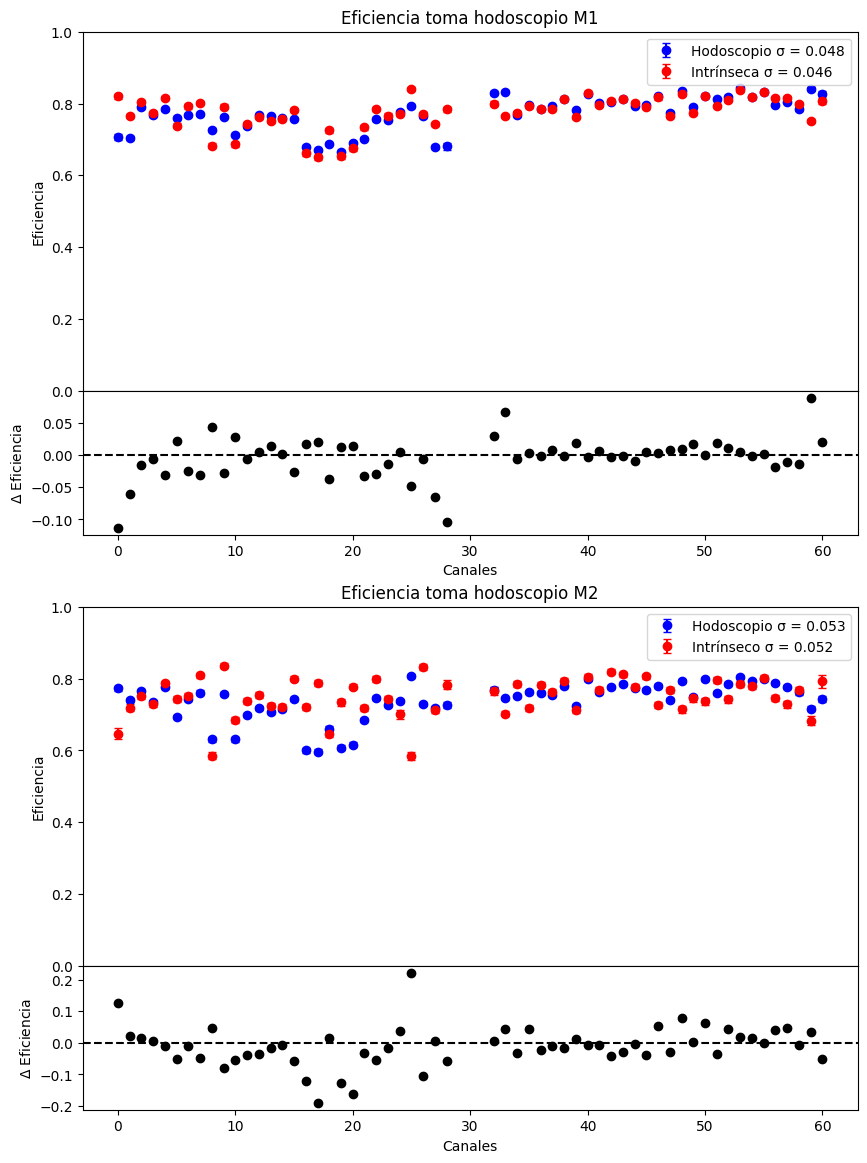

In [ ]:
fig1, ax1 = plt.subplots(
    5, 1, 
    figsize=(10, 14), 
    height_ratios=[1, 0.4, 0.2, 1, 0.4], 
    gridspec_kw={'hspace': 0.001})



ax1[0].errorbar(canales, efi_s, yerr=err_efi_s, fmt='o', color='blue', ecolor='blue', capsize=3, label=f"Hodoscopio σ = {round(std_efi_s,3)}")
ax1[0].errorbar(canales, efi_s0, yerr=err_efi_s0, fmt='o', color='red', ecolor='red', capsize=3, label=f"Intrínseca σ = {round(std_efi_s0,3)}")
ax1[0].set_title("Eficiencia toma hodoscopio M1")
ax1[0].set_ylabel("Eficiencia")
ax1[0].set_ylim(0,1)
ax1[0].legend()

ax1[1].scatter(canales, efi_s-efi_s0, color='black')
ax1[1].axhline(y=0, color='black', linestyle='--')
ax1[1].set_xlabel("Canales")
ax1[1].set_ylabel(r"$\Delta$ Eficiencia")


ax1[2].set_axis_off()

ax1[3].errorbar(canales, efi_b, yerr=err_efi_b, fmt='o', color='blue', ecolor='blue', capsize=3, label=f"Hodoscopio σ = {round(std_efi_b,3)}")
ax1[3].errorbar(canales, efi_b0, yerr=err_efi_b0, fmt='o', color='red', ecolor='red', capsize=3, label=f"Intrínseco σ = {round(std_efi_b0,3)}")
ax1[3].set_title("Eficiencia toma hodoscopio M2")
ax1[3].set_ylabel("Eficiencia")
ax1[3].set_ylim(0,1)
ax1[3].legend()


ax1[4].scatter(canales, efi_b-efi_b0, color='black')
ax1[4].axhline(y=0, color='black', linestyle='--')
ax1[4].set_xlabel("Canales")
ax1[4].set_ylabel(r"$\Delta$ Eficiencia")



plt.tight_layout()